https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Подгружаем все необходимые библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from zipfile import ZipFile
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

Подключаем диск, на котором лежит датасет

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Загружаем датасет в свое рабочее пространство

In [ ]:
!cp /content/drive/MyDrive/data/hymenoptera_data.zip .

file_name = "hymenoptera_data.zip"
with ZipFile(file_name, 'r') as zip:

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


Зададим аугментации для данных

In [ ]:
# RandomResizedCrop - случайное образание изображения и изменение его размера до заданных значений
# https://www.geeksforgeeks.org/randomresizedcrop-method-in-python-pytorch/

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
data_dir = "hymenoptera_data"

# ImageFolder(путь к папке train(val), набор трансформаций)
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Функция для визуализации изображений

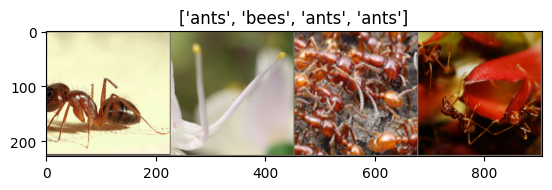

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Функция для тренировки модели

In [ ]:
#scheduler отвечает за изменение lr со временем в процессе обучения
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Инференс + визуализация

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Попробуем два варианта:
1. Файнтюнинг
2. Заморозку слоев и обучение только последнего слоя

Файнтюнинг

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|██████████| 61/61 [01:15<00:00,  1.23s/it]


train Loss: 0.6313 Acc: 0.7131


100%|██████████| 39/39 [00:15<00:00,  2.48it/s]


val Loss: 0.5244 Acc: 0.7778

Epoch 1/9
----------


100%|██████████| 61/61 [01:15<00:00,  1.25s/it]


train Loss: 0.6126 Acc: 0.7746


100%|██████████| 39/39 [00:15<00:00,  2.45it/s]


val Loss: 0.2798 Acc: 0.8889

Epoch 2/9
----------


100%|██████████| 61/61 [01:20<00:00,  1.32s/it]


train Loss: 0.6575 Acc: 0.7787


100%|██████████| 39/39 [00:16<00:00,  2.34it/s]


val Loss: 0.6713 Acc: 0.8497

Epoch 3/9
----------


100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


train Loss: 0.7591 Acc: 0.7623


100%|██████████| 39/39 [00:15<00:00,  2.47it/s]


val Loss: 0.5058 Acc: 0.7908

Epoch 4/9
----------


100%|██████████| 61/61 [01:21<00:00,  1.34s/it]


train Loss: 0.3964 Acc: 0.8279


100%|██████████| 39/39 [00:15<00:00,  2.46it/s]


val Loss: 0.4314 Acc: 0.8301

Epoch 5/9
----------


100%|██████████| 61/61 [01:13<00:00,  1.21s/it]


train Loss: 0.3961 Acc: 0.8361


100%|██████████| 39/39 [00:16<00:00,  2.41it/s]


val Loss: 1.0389 Acc: 0.7451

Epoch 6/9
----------


100%|██████████| 61/61 [01:12<00:00,  1.19s/it]


train Loss: 0.5412 Acc: 0.8033


100%|██████████| 39/39 [00:16<00:00,  2.40it/s]


val Loss: 0.6656 Acc: 0.7908

Epoch 7/9
----------


100%|██████████| 61/61 [01:13<00:00,  1.20s/it]


train Loss: 0.5358 Acc: 0.7869


100%|██████████| 39/39 [00:15<00:00,  2.45it/s]


val Loss: 0.3204 Acc: 0.9085

Epoch 8/9
----------


100%|██████████| 61/61 [01:13<00:00,  1.21s/it]


train Loss: 0.3311 Acc: 0.8648


100%|██████████| 39/39 [00:15<00:00,  2.45it/s]


val Loss: 0.2838 Acc: 0.9020

Epoch 9/9
----------


100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


train Loss: 0.3434 Acc: 0.8852


100%|██████████| 39/39 [00:19<00:00,  1.96it/s]


val Loss: 0.2894 Acc: 0.8954

Training complete in 15m 26s
Best val Acc: 0.908497


2ой вариант - заморозка слоев для извлечения признаков

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 61/61 [00:25<00:00,  2.36it/s]


train Loss: 0.6455 Acc: 0.7049


100%|██████████| 39/39 [00:16<00:00,  2.40it/s]


val Loss: 0.2604 Acc: 0.8954

Epoch 1/9
----------


100%|██████████| 61/61 [00:26<00:00,  2.26it/s]


train Loss: 0.5269 Acc: 0.7295


100%|██████████| 39/39 [00:15<00:00,  2.45it/s]


val Loss: 0.2077 Acc: 0.9281

Epoch 2/9
----------


100%|██████████| 61/61 [00:27<00:00,  2.20it/s]


train Loss: 0.4843 Acc: 0.7828


100%|██████████| 39/39 [00:15<00:00,  2.47it/s]


val Loss: 0.1885 Acc: 0.9412

Epoch 3/9
----------


100%|██████████| 61/61 [00:27<00:00,  2.20it/s]


train Loss: 0.5796 Acc: 0.7377


100%|██████████| 39/39 [00:15<00:00,  2.44it/s]


val Loss: 0.2007 Acc: 0.9346

Epoch 4/9
----------


100%|██████████| 61/61 [00:27<00:00,  2.20it/s]


train Loss: 0.7227 Acc: 0.7131


100%|██████████| 39/39 [00:15<00:00,  2.47it/s]


val Loss: 0.4262 Acc: 0.8431

Epoch 5/9
----------


100%|██████████| 61/61 [00:26<00:00,  2.28it/s]


train Loss: 0.6798 Acc: 0.7746


100%|██████████| 39/39 [00:16<00:00,  2.40it/s]


val Loss: 0.2050 Acc: 0.9477

Epoch 6/9
----------


100%|██████████| 61/61 [00:26<00:00,  2.33it/s]


train Loss: 0.3529 Acc: 0.8607


100%|██████████| 39/39 [00:15<00:00,  2.46it/s]


val Loss: 0.2174 Acc: 0.9542

Epoch 7/9
----------


100%|██████████| 61/61 [00:27<00:00,  2.22it/s]


train Loss: 0.3676 Acc: 0.8402


100%|██████████| 39/39 [00:15<00:00,  2.47it/s]


val Loss: 0.2047 Acc: 0.9477

Epoch 8/9
----------


100%|██████████| 61/61 [00:27<00:00,  2.19it/s]


train Loss: 0.3142 Acc: 0.8811


100%|██████████| 39/39 [00:15<00:00,  2.46it/s]


val Loss: 0.2478 Acc: 0.9412

Epoch 9/9
----------


100%|██████████| 61/61 [00:27<00:00,  2.21it/s]


train Loss: 0.4324 Acc: 0.8279


100%|██████████| 39/39 [00:15<00:00,  2.48it/s]


val Loss: 0.1947 Acc: 0.9477

Training complete in 7m 12s
Best val Acc: 0.954248


Посмотрим на результаты

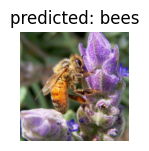

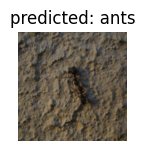

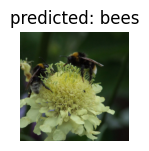

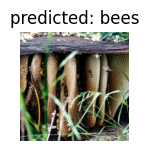

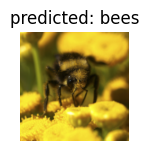

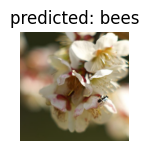

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Функция для инференса на кастомном изображении

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

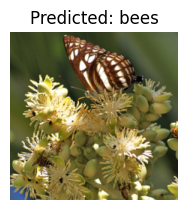

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='./hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()